# Blunder buster
Attemp at trying to identify recurring blunders/mistakes/misses in my chess games.
I am a degen chess player that almost always plays the same opening (some weird english variation).
And I am unwilling to learn the theory, and strictly learn trought many trial and error reps (bullet/blitz/rapid). 
Thus the assumption is that there should be many mistakes done over and over (without me ever noticing them) in roughly simillar positions. Let's try to identify them...

## Content
* [Download games from chess.com](#download-games)
* Evaluate each move of each game and identifying blunders
* Cluster blunder positions based on hamming distance similarity
* Summarize/evaluate results

## Libraries
* `stockfish` - for evaluation (C stockfish needs to be installed on the system, the lib is just a python port). Docs: https://github.com/zhelyabuzhsky/stockfish
* `lc0` - An alternative engine (to stockfish) for evaluation. Lc0 is NN based engine that runs on GPU, thus on my desktop PC runs a bit faster then CPU brute-force based stockfish. Lc0 needs to be first compiled and available in PATH. Then python bindings can be install into an venv by running `pip install  git+https://github.com/LeelaChessZero/lc0.git`. See example: https://github.com/LeelaChessZero/lc0/pull/1261#issuecomment-622951248
* `chessdotcom` - is a convenient chess.com API wrapper lib. Docs: https://chesscom.readthedocs.io/en/latest/index.html
* `chess` - great library that can work with all standard chess notation formats (pgn, fen) and also allows to quickly visualize chess boards in Jupyter. Docs: https://python-chess.readthedocs.io/en/latest/#

## TODO
* Consider/try using `lc0` instead of `stockfish` for evaluation 

In [3]:
import json
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import time
from io import StringIO
from typing import List, Dict, Any
from chessdotcom import ChessDotComClient
from stockfish import Stockfish
from chess import pgn, Board, svg
from sklearn.cluster import DBSCAN
from IPython.display import SVG, display
from scipy.spatial.distance import hamming

# Download Games 

In [4]:
CHESSCOM = ChessDotComClient(user_agent = "My Python Application...")

def get_games(username: str, year: int, month: int) -> List[dict]:
    response = CHESSCOM.get_player_games_by_month(username, year, month)
    json_response = response.json
    return json_response['games']

games = get_games('bowmann', 2024, 9)
games[1]


{'url': 'https://www.chess.com/game/live/118941607467',
 'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2024.09.01"]\n[Round "-"]\n[White "bowmann"]\n[Black "Artichoke60"]\n[Result "0-1"]\n[CurrentPosition "8/P7/8/8/1K6/6k1/8/7q w - -"]\n[Timezone "UTC"]\n[ECO "A11"]\n[ECOUrl "https://www.chess.com/openings/English-Opening-Caro-Kann-Defensive-System...3.Bg2-d5-4.cxd5-cxd5"]\n[UTCDate "2024.09.01"]\n[UTCTime "14:56:33"]\n[WhiteElo "1770"]\n[BlackElo "1753"]\n[TimeControl "600"]\n[Termination "Artichoke60 won by resignation"]\n[StartTime "14:56:33"]\n[EndDate "2024.09.01"]\n[EndTime "15:10:14"]\n[Link "https://www.chess.com/game/live/118941607467"]\n\n1. g3 {[%clk 0:09:59.9]} 1... d5 {[%clk 0:09:57]} 2. Bg2 {[%clk 0:09:59.2]} 2... Nf6 {[%clk 0:09:55.7]} 3. c4 {[%clk 0:09:58.5]} 3... c6 {[%clk 0:09:50.8]} 4. cxd5 {[%clk 0:09:57.1]} 4... cxd5 {[%clk 0:09:49.4]} 5. d3 {[%clk 0:09:57]} 5... e5 {[%clk 0:09:46]} 6. Nf3 {[%clk 0:09:55.6]} 6... Nc6 {[%clk 0:09:44.2]} 7. O-O {[%clk 0:09

# Evaluate Moves
* `pgn` data can be read by `chess` library, and then we can iterate over all moves and feed positions (in `fen` format) to Stockfish for evaluation.
* We will only record moves with significant (_BLUNDER_THRASHOLD) evaluation drop 
* for each such blunder move we will record the best move suggested by stockfish
* In the end we load this all to a pandas Dataframe (color - W/B, result - W/L/D, time_control is in seconds):

| game_uuid | color | fen_position | move | best_move | eval_drop | time_control | result|
|-----------|-------|--------------|------|-----------|-----------|--------------|-------|
|'2c0b08a8-6ec5-11e2-8002-000000000000'| W | 'r4r1k/p6p/1p1p2p1/2q1p3/8/1Q5P/PPP3P1/R4R1K w - - 0 23'| 'f1f8' | 'b3e6' | 0.7 | 600 | L|

## TODO

* Empirically find out what is the best _BLUNDER_THRASHOLD value
* Empirically find out what are the best stockfish params
* Consider Lc0 engine instead of Stockfish - running stockfish on my current CPU (6cores/12threads) doesn't seem to be the best option

In [5]:
# Set analyses parameters
_BLUNDER_THRASHOLD = 0.3
_STOCKFISH_PARAMS = {
    "Threads": 10,
    "Skill Level": 20,
    "Hash": 4096,
#    "Hash": 8192,
}
_STOCKFISH_DEPTH = 18
# Only consider first 10 moves of every game (i.e. opening-ish moves)
_FIRST_N_MOVES = 10

In [8]:
def analyze_game_stockfish(game_pgn: str, focus: int) -> List[dict]:
    """Analyze game by iterating over all game moves and evaluating each position.
    Focus only on moves of the particular player specified by `focus` param (0 for white 
    and 1 for black).
    """
    _pgn = StringIO(game_pgn)
    game = pgn.read_game(_pgn)
    board = game.board()
    stockfish = Stockfish(depth=_STOCKFISH_DEPTH, parameters=_STOCKFISH_PARAMS)
    stockfish.set_fen_position(board.fen())
    blunders = []
    evaluation = 0
    eval_before = 0
    best_move = None
    # 0 -white, 1-black
    # according to the latest and greatest chess rules, white always starts.
    player = 0
    # Iterate over game moves
    focus_move_count = 0
    for move in game.mainline_moves():
        
        pos_before = board.fen()
        eval_before = evaluation
        best_move_before = best_move
        
        # Play the move
        board.push(move)
        
        # Send the position to stockfish and evaluate
        stockfish.set_fen_position(board.fen())
        eval_before, evaluation = evaluation, stockfish.get_evaluation()['value'] / 100
        best_move = stockfish.get_best_move()

        eval_diff = eval_before - evaluation
        # Record blunders for "in-focus" player
        if eval_diff > _BLUNDER_THRASHOLD and focus == player:
            blunders.append({
                'move': str(move),
                'best_move': str(best_move_before),
                'fen_position': pos_before,
                'eval_drop': eval_diff,
                'color': ['w', 'b'][player],
            })

        focus_move_count += focus == player
        if focus_move_count == _FIRST_N_MOVES:
            break
        player = (player + 1) % 2
            
    return blunders

def find_blunders(username: str, year: int, month: int):
    """ Analyze all games for the specified chess.com `username` in the
    given `year` and `month` time period.
    """
    games = get_games(username, year, month)
    blunders = []
    for game in games:
        #print("\nanalyzing game:", game['uuid'])
        focus_player = int(username != game['white']['username'])
        game_blunders = analyze_game_stockfish(game['pgn'], focus_player)
        game_result = [game['white']['result'], game['black']['result']][focus_player]
        for b in game_blunders:
            b.update({
                'game_uuid': game['uuid'],
                'result': game_result,
                'time_control': game['time_control']
            })
        yield game_blunders

In [9]:
b_df = pd.DataFrame()
for month in range(1,13):
    for game_b in find_blunders('bowmann', 2024, month):
        game_b_df = pd.DataFrame.from_records(game_b)
        b_df = pd.concat([b_df, game_b_df], ignore_index=True)
        b_df.to_csv("data/2024_first10_blunders_10_20_4096_18.csv")

KeyboardInterrupt: 

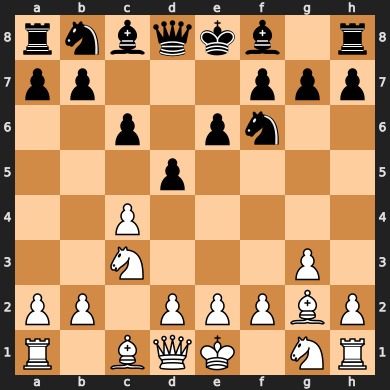

In [10]:
#blunders[:2]
#blunders = pd.read_csv('data/blunders.csv')
display(Board(b_df.iloc[1]['fen_position']))

In [11]:
games[:2]

[{'url': 'https://www.chess.com/game/live/118932035867',
  'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2024.09.01"]\n[Round "-"]\n[White "bowmann"]\n[Black "deepblue26"]\n[Result "0-1"]\n[CurrentPosition "5k2/7p/1pB2P2/1Pr3P1/3K3P/8/p7/8 w - -"]\n[Timezone "UTC"]\n[ECO "A20"]\n[ECOUrl "https://www.chess.com/openings/English-Opening-Kings-English-Variation...3.Bg2-d5-4.cxd5-Nxd5"]\n[UTCDate "2024.09.01"]\n[UTCTime "12:19:51"]\n[WhiteElo "1779"]\n[BlackElo "1799"]\n[TimeControl "600"]\n[Termination "deepblue26 won by resignation"]\n[StartTime "12:19:51"]\n[EndDate "2024.09.01"]\n[EndTime "12:33:13"]\n[Link "https://www.chess.com/game/live/118932035867"]\n\n1. g3 {[%clk 0:09:58.1]} 1... d5 {[%clk 0:09:58.3]} 2. Bg2 {[%clk 0:09:52.2]} 2... Nf6 {[%clk 0:09:54.3]} 3. c4 {[%clk 0:09:46.4]} 3... e5 {[%clk 0:09:47.2]} 4. cxd5 {[%clk 0:09:44.7]} 4... Nxd5 {[%clk 0:09:45.5]} 5. d3 {[%clk 0:09:43.7]} 5... Bb4+ {[%clk 0:09:25.9]} 6. Bd2 {[%clk 0:09:42.1]} 6... Bxd2+ {[%clk 0:09:18.2]} 

# Clustering 

The actual blander moves (e.g., f, in my opinion, is far less important than the position/structure/pattern from which 
Now we will attempt to cluster the blunder positions based on their similarity. 

## Fen position normalization
To be able to use hamming distance for computing distance matrix (that can be later used for clustering) we need to normalize the positions to the same length:
* First we remove fen notation "metadata"
* and then we expand numbers to "dashes" (2p5 to --p-----)

this will yield position strings of 8*8 length (plus 7 separating backslashes)

In [12]:
def normalize(position: str) -> str:
    # Strip fen metadata 
    # i.e. this:
    # "rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq c6 0 2"
    # to this:
    # "rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR"
    position = position.split()[0]

    # Now mormalize to the same lenght by expanding num values like this
    # 2p5 to --p-----
    normalized = ''
    #TODO: This is more of an idea: also uppercase and in rotate for on color 
    for x in position:
        if x in '12345678':
            normalized += int(x)*'-'
        else:
            normalized += x
    return normalized

Once we have the positions normalized we can calculate the (hamming) distance matrix for our positions

In [13]:
def distance_matrix(norm_pos):
    pos_n = len(norm_pos)
    dm = np.zeros((pos_n, pos_n))
    for i, i_pos in enumerate(norm_pos):
        for j, j_pos in enumerate(norm_pos):
            dm[i][j] = hamming(list(i_pos), list(j_pos))
    return dm 

def cluster_blunder_positions(positions):
    normalized_pos = list(map(normalize, positions))
    dm = distance_matrix(normalized_pos)
    db = DBSCAN(metric='precomputed', eps=0.02)
    return db.fit_predict(dm)

w_pos = b_df[b_df["color"] == 'w']["fen_position"]
b_pos = b_df[b_df["color"] == 'b']["fen_position"]
w_clusters = cluster_blunder_positions(w_pos)
#b_clusters = cluster_blunder_positions(b_pos)
w_clusters

array([ 0,  1, -1, ..., -1,  2, 59], shape=(5186,))

(array([3261.,   41.,   40.,  382.,  451.,   89.,   24.,   29.,    8.,
          63.,    8.,    8.,   26.,   27.,   13.,    9.,   12.,    7.,
          11.,    8.,    7.,   21.,    7.,   42.,    9.,   16.,   10.,
           7.,    9.,   14.,    5.,   10.,    5.,   84.,    6.,    7.,
           6.,    9.,   16.,   13.,    5.,    7.,    5.,   21.,    7.,
           8.,    6.,    9.,    8.,   11.,    7.,   21.,    5.,    5.,
           7.,   10.,    7.,    8.,    5.,   10.,   19.,   12.,    8.,
           6.,    5.,   25.,    7.,    6.,    5.,    5.,   13.,    5.,
           5.,    5.,   16.,    5.,    8.,    6.,    5.,   10.,    5.,
          13.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
        38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
        51., 52., 53., 54., 55., 56., 57., 58., 59.,

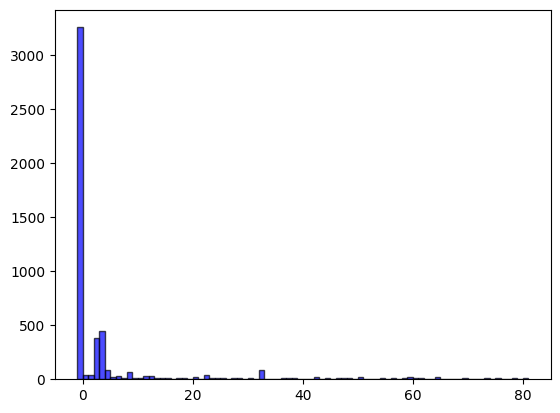

In [14]:
# Lets plot histogram of our clusters/groups 
plt.hist(w_clusters, bins=np.max(w_clusters)+1, alpha=0.7, color='blue', edgecolor='black')

In [15]:
w_groups = {}
for i, i_g in enumerate(w_clusters):
    if i_g not in w_groups:
        w_groups[int(i_g)] = []
    blunder_idx = w_pos.index[i]
    w_groups[int(i_g)].append(b_df.iloc[blunder_idx])

In [17]:
def draw_blunder(blunder):
    # Draw blunder (position, blunder move and the best suggested move)
    b = Board(blunder['fen_position'])
    m = blunder['move']
    b_m = blunder['best_move']
    arrow_move = svg.Arrow.from_pgn(f"R{m}")
    arrow_best_move = svg.Arrow.from_pgn(f"G{b_m}")
    return svg.board(b, arrows=[arrow_move, arrow_best_move], size=300)

def draw_group(group):
    # Draw first 10 blunder positions from the given blunder group
    group_images = [SVG(draw_blunder(b)) for b in group[:10]]
    group_game_ids = [b['game_uuid'] for b in group[:10]]
    for idx, img in enumerate(group_images):
        print(group_game_ids[idx])
        display(img)

# Results



116e29cd-b1a0-11ee-8ec0-6cfe544c0428


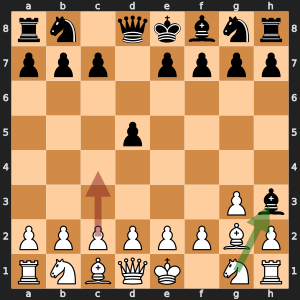

53f25348-c16d-11ee-8402-6cfe544c0428


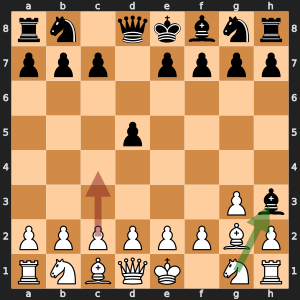

526568a9-e22c-11ee-9509-6cfe544c0428


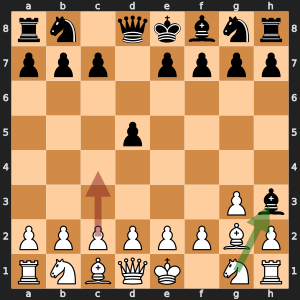

fbf46e69-e2cc-11ee-ba9f-6cfe544c0428


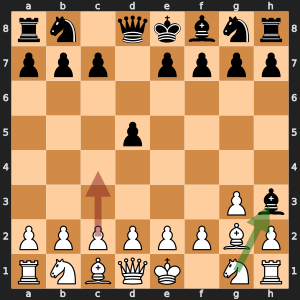

ce2f59e3-ec81-11ee-bd0d-6cfe544c0428


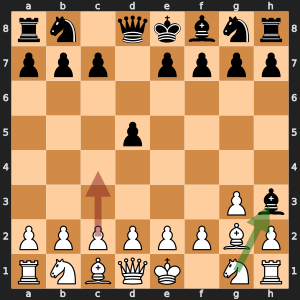

In [18]:
# Here the clustering nicely detected one of the most annoying tricks 
# you can fall for if you play fianchetto type opening in bullet games...
draw_group(w_groups[31])